# Financial data analysis

The main idea of this notebook is to collect and analyze financial and economic data of companies which shares are listed on Moscow stock exchange.
The list of such shares and all the data we need are presented on https://smart-lab.ru.

First of all, some comments about secure connection to Jupyter Notebook from virtual machine. It's based on guide available at https://github.com/girafe-ai/msai-python/blob/2020-2021/remote_machine_setup_guide.md  
1. Create a new security group. On the EC2 instance page go to the “Security Groups” section and add properties for ssh, https and custom tcp rules. Then assign this group to instance.  
2. Create a file `run_jupyter.sh` to start jupyter:  
`touch run_jupyter.sh  
echo "jupyter notebook --no-browser --port XXXX --ip 0.0.0.0">run_jupyter.sh  
chmod +x run_jupyter.sh`  
`XXXX` here is a port number  
3. Create a password for the jupyter notebook:  
`jupyter notebook --generate-config  
jupyter notebook password`  
4. Run `run_jupyter.sh`.  
5. Type in browser https://ADDRESS:XXXX, where ADDRESS is virtual machine Public IPv4 address and XXXX is a port number defined in p.2.  
Starting jupyter window with a field to enter password appears

In [1]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import io
import matplotlib.pyplot as plt
import re
import requests

from bs4 import BeautifulSoup
from pymongo import MongoClient

The list of shares is on https://smart-lab.ru/q/shares_fundamental/.

In [2]:
resp = requests.get('https://smart-lab.ru/q/shares_fundamental/')
soup = BeautifulSoup(resp.text, 'html.parser')

Each entry in the table has a hyperlink to detailed information about selected share. A corresponding tag has a path like 'q/TICKER/f/y/', where TICKER is a ticker code. Clicking on the link we go to a share's page where there is one more useful link `Финансовая Отчетность`. This link leads to required report with data.  
For example, clicking on `ГАЗПРОМ ао`, we go to its page. Then click on `Финансовая Отчетность` on the top left part and go to financial report.  
So we need to find all the links to financial reports.  
Note that there is an easy way to do it: we can get needed pathes directly on the start page. It's stored in lines with corresponging shares. But in educational purposes let's get them in more sophisticated way using different methods of BeautifulSoup library.

In [3]:
# we will store links in a dict {share_name: report_link}
report_links  ={}
# find all the <a> tags where path contains "/forum/"
#share_tags = soup.find_all('a', title=re.compile("^Форум акций"))
share_tags = soup.find_all(href=re.compile("/forum/" + "[A-Z]+$"))

for tag in share_tags:
    # add a prefix since initial path is relative
    share_link = 'https://smart-lab.ru' + tag['href']
    # get share name
    share_name = tag.string
    # get page content
    share_main_page = requests.get(share_link)
    share_soup = BeautifulSoup(share_main_page.text, 'html.parser')
    # required text 'Финансовая Отчетность' is <span> tag inside <a> tag
    # so to get a path we need to find a parent of <span> tag
    share_report_tag = share_soup.find(string="Финансовая Отчетность").find_parents('a')
    # one more time add a prefix 
    share_report_link = 'https://smart-lab.ru' + share_report_tag[0]['href']
    report_links[share_name] = share_report_link
# if share_tags is empty (for example, the link is unavailable),  generate artificial dict
if len(share_tags) == 0:
    report_links = {
    'Сбербанк': 'https://smart-lab.ru/q/SBER/f/y/',
     'ГАЗПРОМ ао': 'https://smart-lab.ru/q/GAZP/f/y/',
     'ЛУКОЙЛ': 'https://smart-lab.ru/q/LKOH/f/y/',
     'Роснефть': 'https://smart-lab.ru/q/ROSN/f/y/',
     'Yandex clA': 'https://smart-lab.ru/q/YNDX/f/y/',
     'Магнит ао': 'https://smart-lab.ru/q/MGNT/f/y/'}
next(iter(report_links.items()))

('Газпром', 'https://smart-lab.ru/q/GAZP/f/y/')

Take a look at some report

In [4]:
share_example, report_link_example = next(iter(report_links.items()))                                        
report_page = requests.get(report_link_example)
report_soup = BeautifulSoup(report_page.text, 'html.parser')

There is an option to download all the data as csv file (look at the corresponding button on the top right part). We need to get this link address. Note that corresponding tag has class `download-table`.   

Create pandas dataframe out of this file.

In [5]:
download_tag = report_soup.find_all('a', class_="download-table")
download_link = 'https://smart-lab.ru' + download_tag[0]['href']
report_content = requests.get(download_link).content
df = pd.read_csv(io.StringIO(report_content.decode('utf-8')), sep=';')
df.head(10)

,Unnamed: 0,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,LTM
0,Дата отчета,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.04.2019,...,19.05.2018,10.04.2019,10.04.2019,26.04.2018,26.04.2018,29.04.2019,29.04.2020,29.04.2021,NaN,29.11.2021
1,Валюта отчета,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,...,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB
2,"Добыча нефти, млн т",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.8,43.5,44.0,47.2,48.6,48.3,48.0,47.1,NaN,49.4
3,"Переработка нефти, млн т",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.1,68.0,66.8,65.9,64.1,67.4,55.0,53.7,NaN,NaN
4,"Добыча газа, млрд м3",NaN,512.0,525.6,547.6,552.5,555.0,556.0,548.6,549.7,...,488.4,444.9,419.5,420.1,472.0,498.7,501.0,454.5,514.8,511.2
5,"Экспорт газа, млрд м3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.8,...,161.5,146.6,158.6,179.3,194.4,243.3,232.4,219.0,NaN,240.0
6,"Цена газа на экспорт, $/1000 м3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410,...,381,350,246,176,200,248,210,143,NaN,313
7,"Выручка, млрд руб",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 775,2 507,...,5 250,5 590,6 073,6 111,6 546,8 224,7 659,6 321,NaN,8 745
8,"Операционная прибыль, млрд руб",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1 120,615.0,NaN,1 879
9,"EBITDA, млрд руб",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2 010,1 963,1 875,1 322,1 467,2 599,1 860,1 466,NaN,2 760


To use thia data for futher analysis, make some preprocessing:  
- rename column with coefficients from `Unnamed: 0` to `coeff`  
- delete useless rows  
- 'flatten' dataframe: move years from columns to rows  
- delete rows with NaN and zero values. 
- delete rows where year = LTM
- add share name

In [6]:
df.rename(columns={'Unnamed: 0':'coeff'}, inplace=True)
rows_to_delete = ['Дата отчета', 'Валюта отчета', 
                  'IR рейтинг', 'Качество фин.отчетности', 'Презентации для инвесторов', 
                  'Присутствие на смартлабе', 'Годовой отчет', 'Сайт для инвесторов', 
                  'Календарь инвесторов', 'Обратная связь']
index_to_delete = df[df["coeff"].isin(rows_to_delete)].index
df.drop(index_to_delete, inplace = True)
df = df.melt(id_vars=["coeff"], 
        var_name="year", 
        value_name="value")
df = df[df['value'].notna()]
df = df[df['value'] != "0.00"]
df = df[df['year'] != "LTM"]
df["share"] = share_example
df.head(10)

,coeff,year,value,share
13,"Дивиденд, руб/акцию",2000,"0,3",Газпром
14,"Див доход, ао, %",2000,3.4%,Газпром
25,"Цена акции ао, руб",2000,8.80,Газпром
26,"Число акций ао, млн",2000,23 673,Газпром
29,"Капитализация, млрд руб",2000,208.3,Газпром
30,"EV, млрд руб",2000,208.3,Газпром
37,"Доходность FCF, %",2000,0.0%,Газпром
52,"Добыча газа, млрд м3",2001,512.0,Газпром
63,"Дивиденд, руб/акцию",2001,"0,44",Газпром
64,"Див доход, ао, %",2001,2.0%,Газпром


Looks fine. Save data as json file

In [7]:
with open('data_example.json', 'w', encoding='utf-8') as file:
    df.to_json(file, force_ascii=False, orient='index')

Now let's save "clear" data in MondoDB. Create a database called `shares_example`and corresponding collection `shares_collection_example`.

In [8]:
client = MongoClient('mongo', 27017)
db_example = client.shares_example
collection_example = db_example.shares_collection_example
db_example.collection_example.insert_many(df.to_dict('records'))

Now let's repeat for each share and save all the data in a database `shares`, collection `collection`

In [9]:
# define final dataframe
#total_df = pd.DataFrame(columns=['coeff','year','value','share'])
db = client.shares
collection = db.collection
for share, page in report_links.items():
    # get report page content and find a link to download
    report_page = requests.get(page)
    report_soup = BeautifulSoup(report_page.text, 'html.parser')
    download_tag = report_soup.find_all('a', class_="download-table")
    if download_tag:
        download_link = 'https://smart-lab.ru' + download_tag[0]['href']
        report_content = requests.get(download_link).content
        # create dataframe and make it useful for analysis
        df = pd.read_csv(io.StringIO(report_content.decode('utf-8')), sep=';')
        df.rename(columns={'Unnamed: 0':'coeff'}, inplace=True)
        index_to_delete = df[df["coeff"].isin(rows_to_delete)].index
        df.drop(index_to_delete, inplace = True)
        df = df.melt(id_vars=["coeff"], 
                var_name="year", 
                value_name="value")
        df = df[df['value'].notna()]
        df = df[df['value'] != "0.00"]
        df = df[df['year'] != "LTM"]
        df["share"] = share
        # add to final dataframe
        #total_df = total_df.append(df, ignore_index=True)
        if not df.empty:
            #total_df = pd.concat([total_df, df], sort=False, ignore_index=True)
            db.collection.insert_many(df.to_dict('records'))
#total_df.head(10)
print(f"The database has {db.collection.count_documents({})} documents")

The database has 115715 documents


Well, data is almost ready to use.  
For example, we're interested in coefficient `Чистая прибыль, млрд руб`. Let's find top5 shares with highest average net profit and look at the dynamics by years.

Firstly, load from `shares` database documents with corresponding coefficient name and create a dataframe out of this data. Using Pandas methods we can find top5 shares

In [10]:
db_mongo = client['shares']
cursor = db_mongo['collection'].find({"coeff": "Чистая прибыль, млрд руб"})
df_profit =  pd.DataFrame(list(cursor))
# some adjustments to make 'value' column numerical
df_profit["value"] = df_profit["value"].str.replace(' ', '')
df_profit["value"] = df_profit["value"].str.replace(',', '')
df_profit["value"] = df_profit["value"].astype(float)
top5_shares = df_profit.groupby('share')['value'].mean().sort_values(ascending=False)[0:5].index.tolist()
top5_shares

['ГАЗПРОМ ао', 'Газпром', 'Сбербанк-п', 'Сбербанк', 'Роснефть']

Now let's plot the graphs.

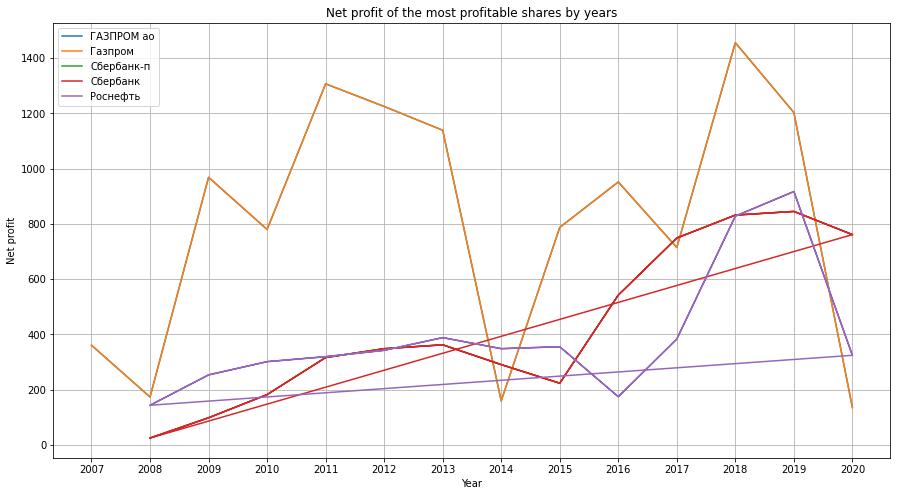

In [11]:
df_profit_top5 = df_profit[df_profit['share'].isin(top5_shares)]
fig, ax = plt.subplots(figsize=(15, 8))
for share in top5_shares:
    part = df_profit_top5[df_profit_top5["share"] == share]
    ax.plot(part["year"], part["value"], label=share)       
ax.set_ylabel("Net profit")
ax.set_xlabel("Year")
ax.set_title("Net profit of the most profitable shares by years")
ax.legend()
ax.grid()